<a href="https://colab.research.google.com/github/dmitry-kabanov/datascience/blob/main/2021_12_12_rolling_regression_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rolling regression with PyMC3

Source: https://towardsdatascience.com/rockin-rolling-regression-in-python-via-pymc3-e4722b6118cd

We work with data where the model parameters are supposed to change in time:
$$
y = a(t) x + b(t).
$$
This means that we need to use rolling regression by adding new observations and fitting again.

## Setup

In [62]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-deep")
plt.style.use("seaborn-notebook")

FIGSIZE_DEFAULT = matplotlib.rcParams["figure.figsize"]
FIGSIZE_WIDE = 2*FIGSIZE_DEFAULT[0], FIGSIZE_DEFAULT[1]

## Data

In [12]:
url = "https://raw.githubusercontent.com/Garve/datasets/3b6b1e6fadc04e2444905db0a0b2ed222daeaa28/rolling_data.csv"
data = pd.read_csv(url, index_col="t")

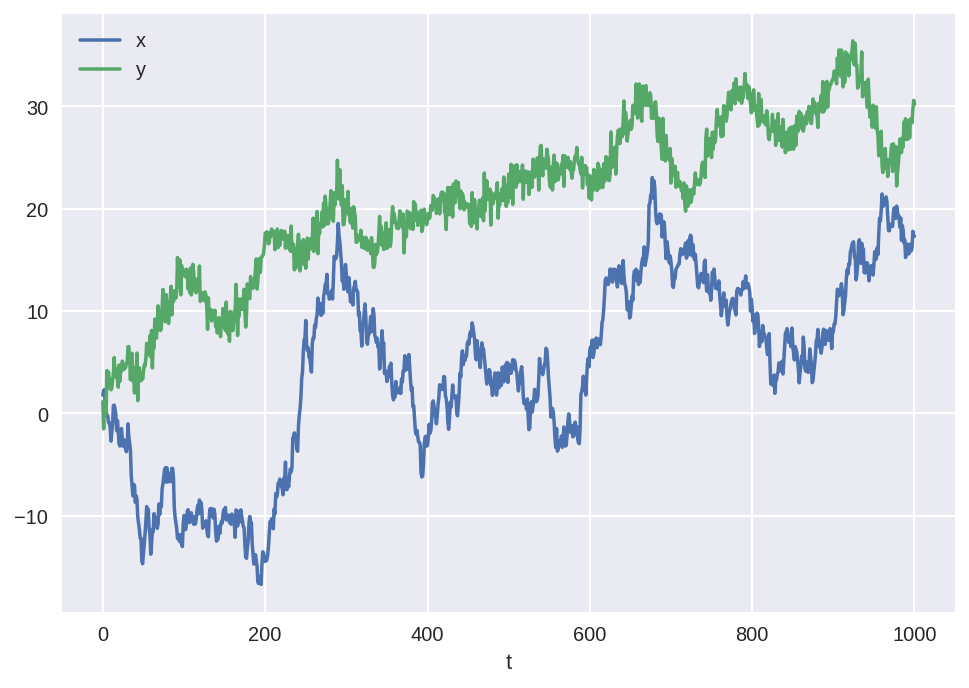

In [18]:
data.plot();

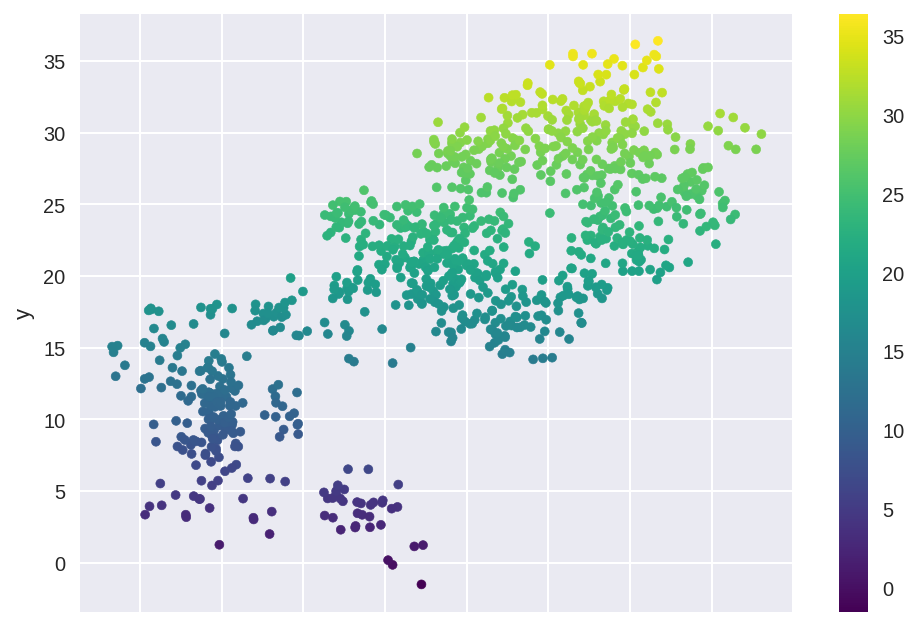

In [49]:
data.plot.scatter("x", "y", c=data["y"], colormap="viridis");

In [50]:
data.head(20)

,x,y
t,,
0,1.788628,1.132007
1,2.225138,-1.519656
2,2.321636,1.222515
3,0.458143,-0.154748
4,0.180755,0.171896
5,-0.174004,4.178688
6,-0.256746,2.635478
7,-0.883746,4.028227
8,-0.927564,2.466614


## Linear regression on all data

In [31]:
X = data[['x']]
y = data['y']

lr = LinearRegression().fit(X, y)
print(f"Intercept = {lr.intercept_:.5f}, slope={lr.coef_[0]:.3f}")

Intercept = 18.45587, slope=0.593


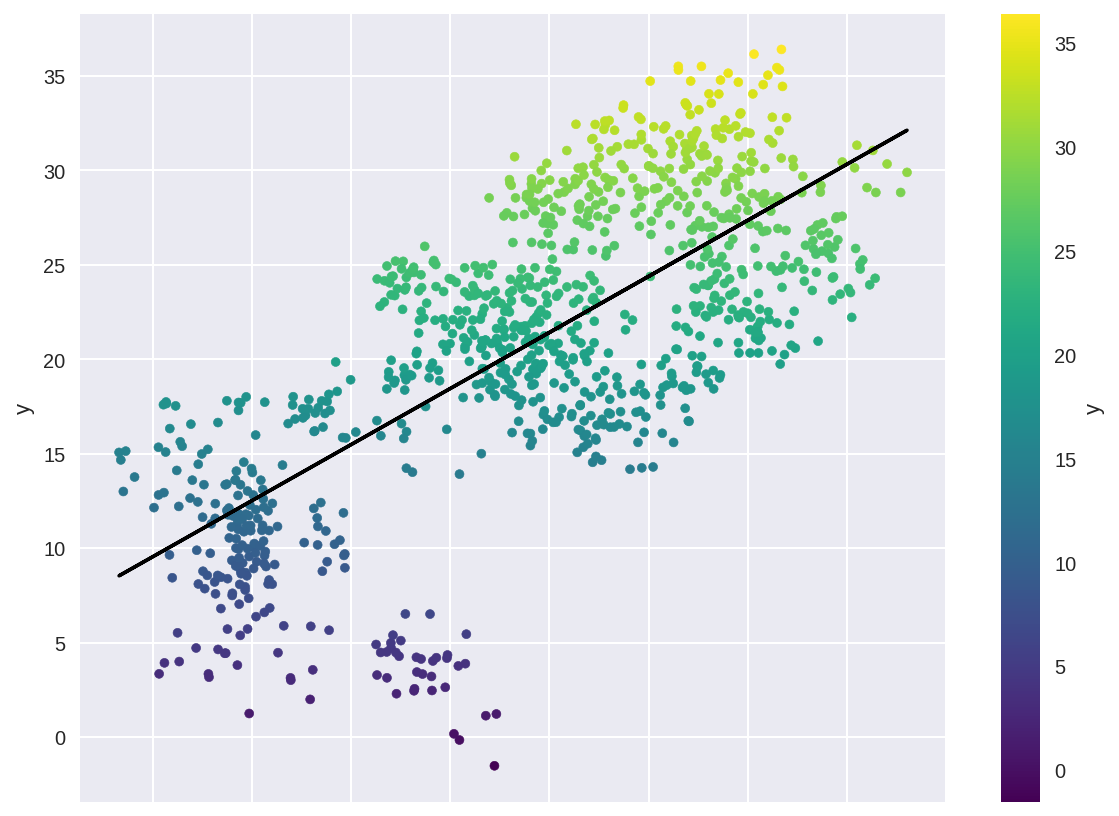

In [48]:
data.plot.scatter(x="x", y="y", c="y", colormap="viridis");
plt.plot(data["x"], lr.coef_[0]*data['x'] + lr.intercept_, "k-");
plt.xlabel("x");
plt.tight_layout(pad=0.1);

## Poor Man's Rolling Regression

We make a sliding window of observations and do sequential fitting to these windows.

In [51]:
w = 30  # Window length

slopes = []
intercepts = []

for i in range(len(data) - w):
    X = data.loc[i:i+w, ["x"]]
    y = data.loc[i:i+w, "y"]

    lr = LinearRegression()
    lr.fit(X, y)
    intercepts.append(lr.intercept_)
    slopes.append(lr.coef_[0])

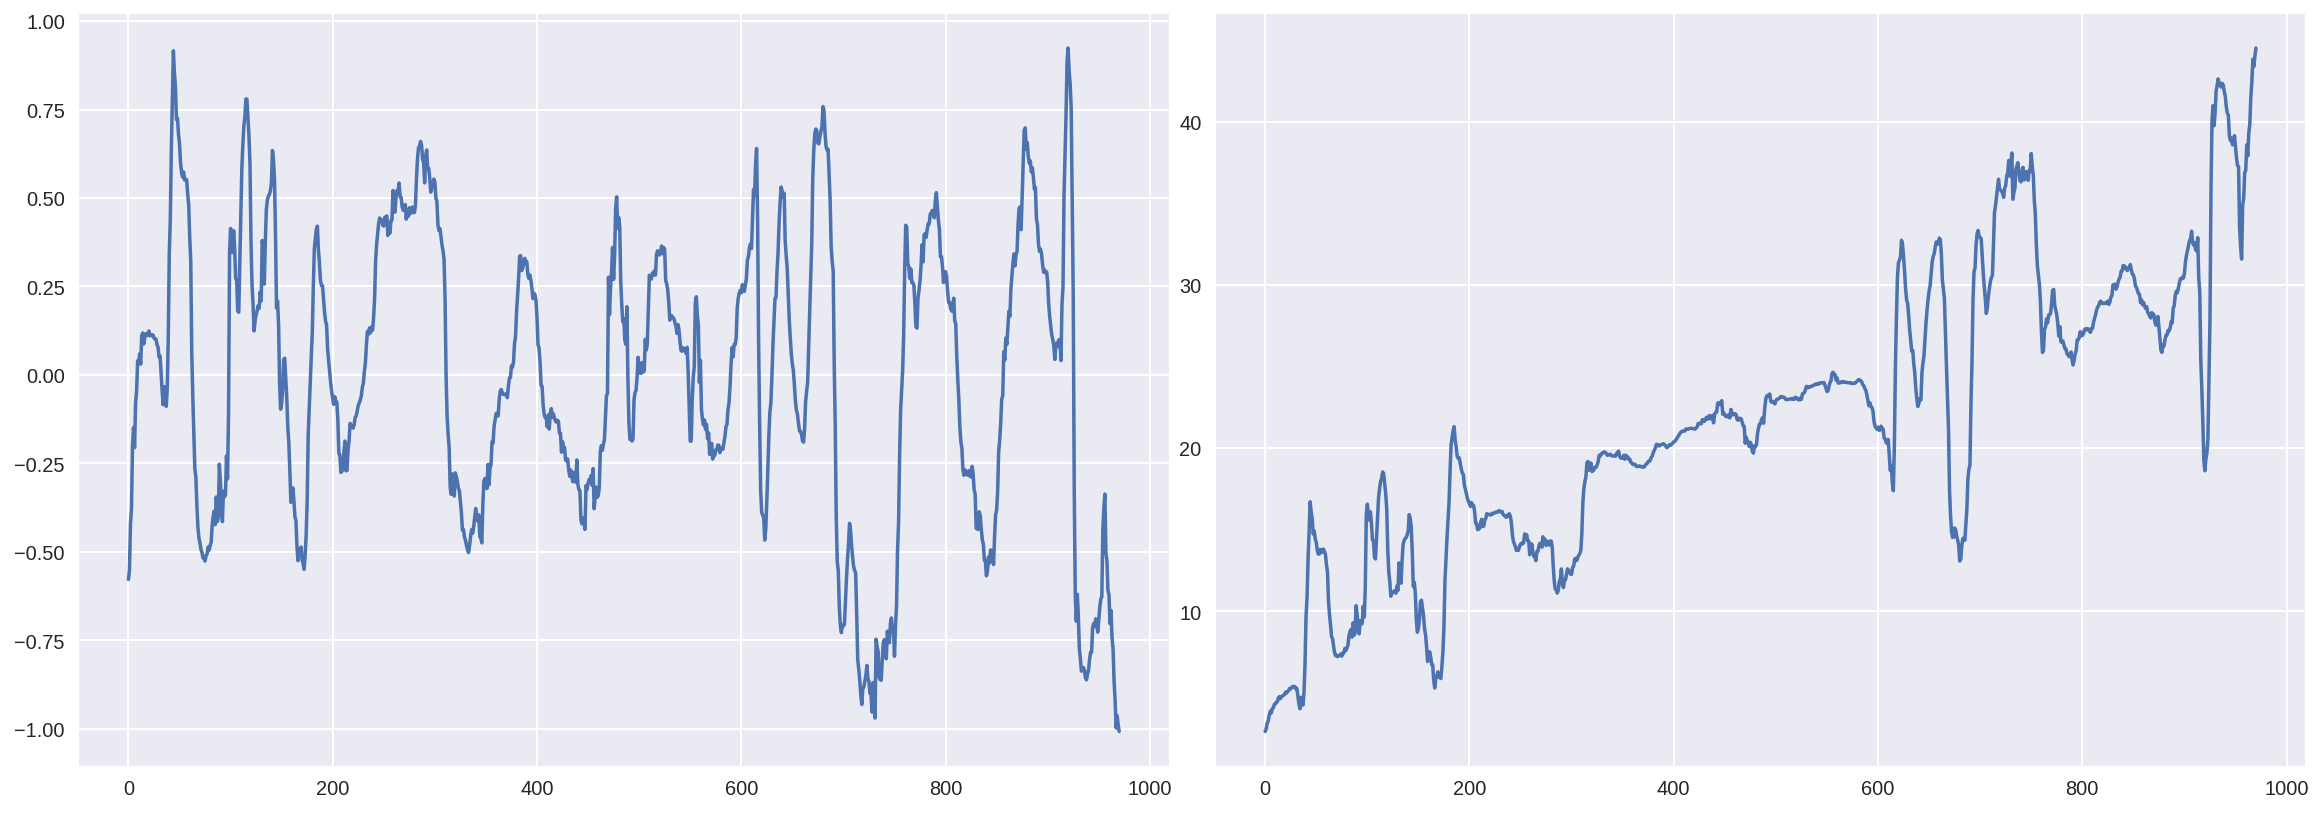

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=FIGSIZE_WIDE)
axes[0].plot(slopes, "-");
axes[1].plot(intercepts, "-");
fig.tight_layout(pad=0.1);

We can see that the parameters change rather nonsmoothly over time. If we increase the window length, we can expect that they will vary more smoothly.
This is due to the fact that the larger $w$, the more overlapping two neighboring windows are, which means that the results of linear regression on them will be close to each other.

In [55]:
w = 200  # Window length

slopes = []
intercepts = []

for i in range(len(data) - w):
    X = data.loc[i:i+w, ["x"]]
    y = data.loc[i:i+w, "y"]

    lr = LinearRegression()
    lr.fit(X, y)
    intercepts.append(lr.intercept_)
    slopes.append(lr.coef_[0])

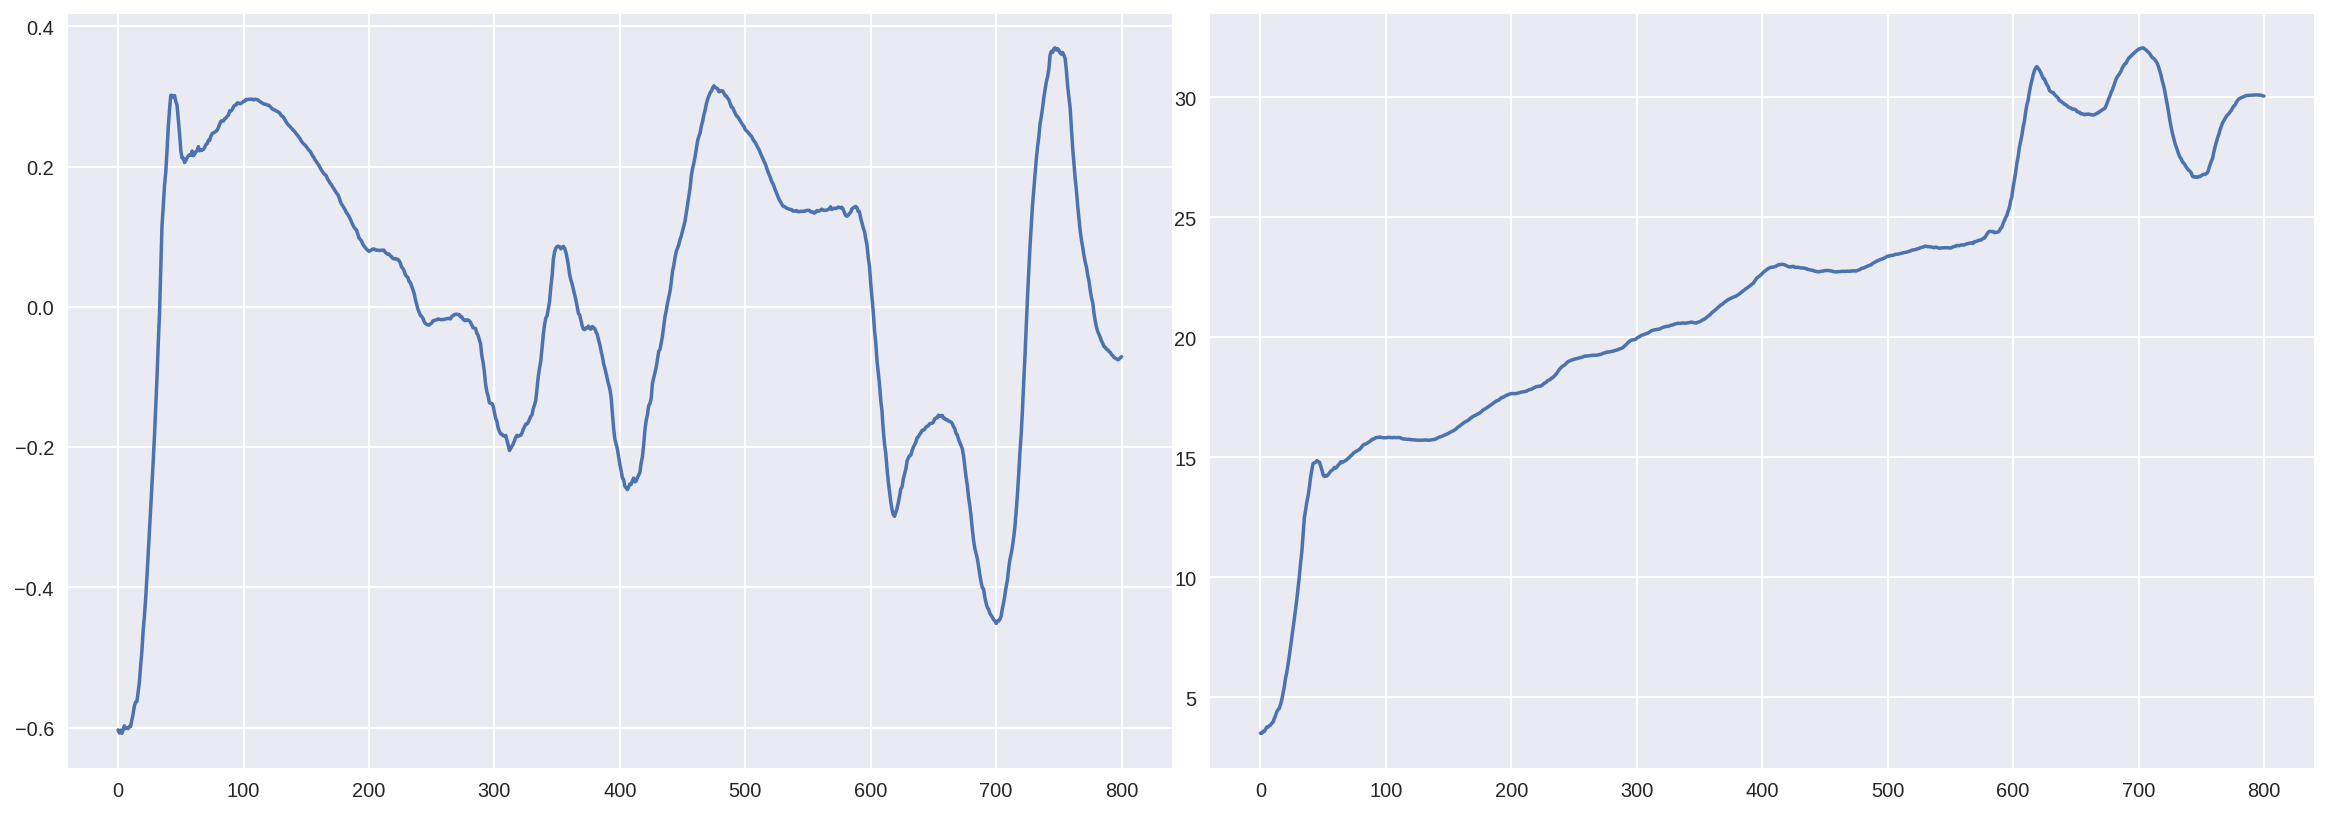

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=FIGSIZE_WIDE)
axes[0].plot(slopes, "-");
axes[1].plot(intercepts, "-");
fig.tight_layout(pad=0.1);

## Bayesian Rolling Regression

Let's use pyMC3 package to do Bayesian approach, that is, by specifying distributions of sought-for random variables:

In [58]:
with pm.Model() as linear_model:
    slope = pm.Normal("slope", sigma=1)  # a
    intercept = pm.Normal("intercept", sigma=1)  # b
    noise = pm.Exponential("noise", lam=1)

    y = pm.Normal(
        "y",
        mu=slope*data["x"] + intercept,  # Equation of the model
        sigma = noise,
        observed=data["y"],
    )

    linear_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, intercept, slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


### Gaussian random walks

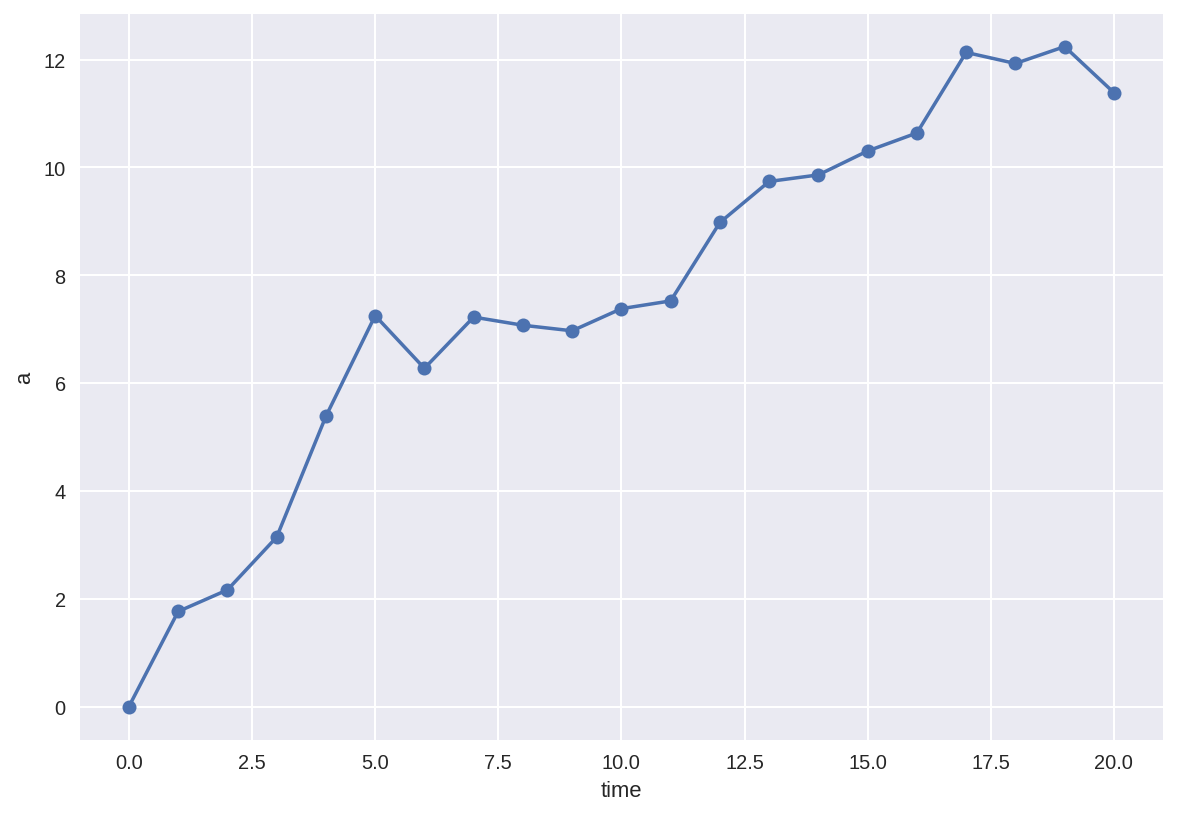

In [64]:
np.random.seed(0)

steps = 20
a = [0]
sigma = 1

for t in range(steps):
    a.append(np.random.normal(a[-1], sigma))

plt.figure()
plt.plot(range(steps+1), a, "o-");
plt.xlabel("time");
plt.ylabel("a");
plt.tight_layout(pad=0.1);

## PyMC3 model

In [65]:
with pm.Model() as rolling_linear_model:
    # Noise parameters
    sigma_slope = pm.Exponential("sigma_slope", lam=1)
    sigma_intercept = pm.Exponential("sigma_intercept", lam=1)
    sigma = pm.Exponential("sigma", lam=1)

    # Gaussian random walks
    slopes = pm.GaussianRandomWalk(
        "slopes",
        sigma=sigma_slope,
        shape=len(data),
    )
    intercepts = pm.GaussianRandomWalk(
        "intercepts",
        sigma=sigma_intercept,
        shape=len(data),
    )

    # Putting it together
    y = pm.Normal(
        "y",
        slopes*data["x"] + intercepts,
        sigma,
        observed=data["y"],
    )

    rolling_linear_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercepts, slopes, sigma, sigma_intercept, sigma_slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 933 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [66]:
import arviz as az

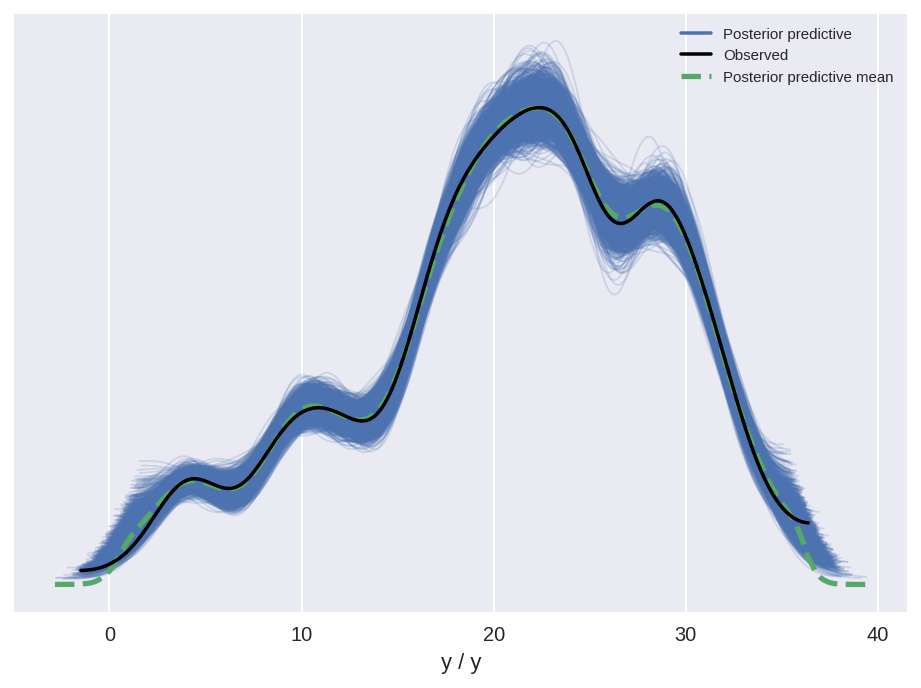

In [67]:
with rolling_linear_model:
    posterior = pm.sample_posterior_predictive(rolling_linear_trace)
    az.plot_ppc(az.from_pymc3(posterior_predictive=posterior))

In [69]:
az.r2_score(data["y"].values, posterior["y"])

r2        0.981442
r2_std    0.000982
dtype: float64

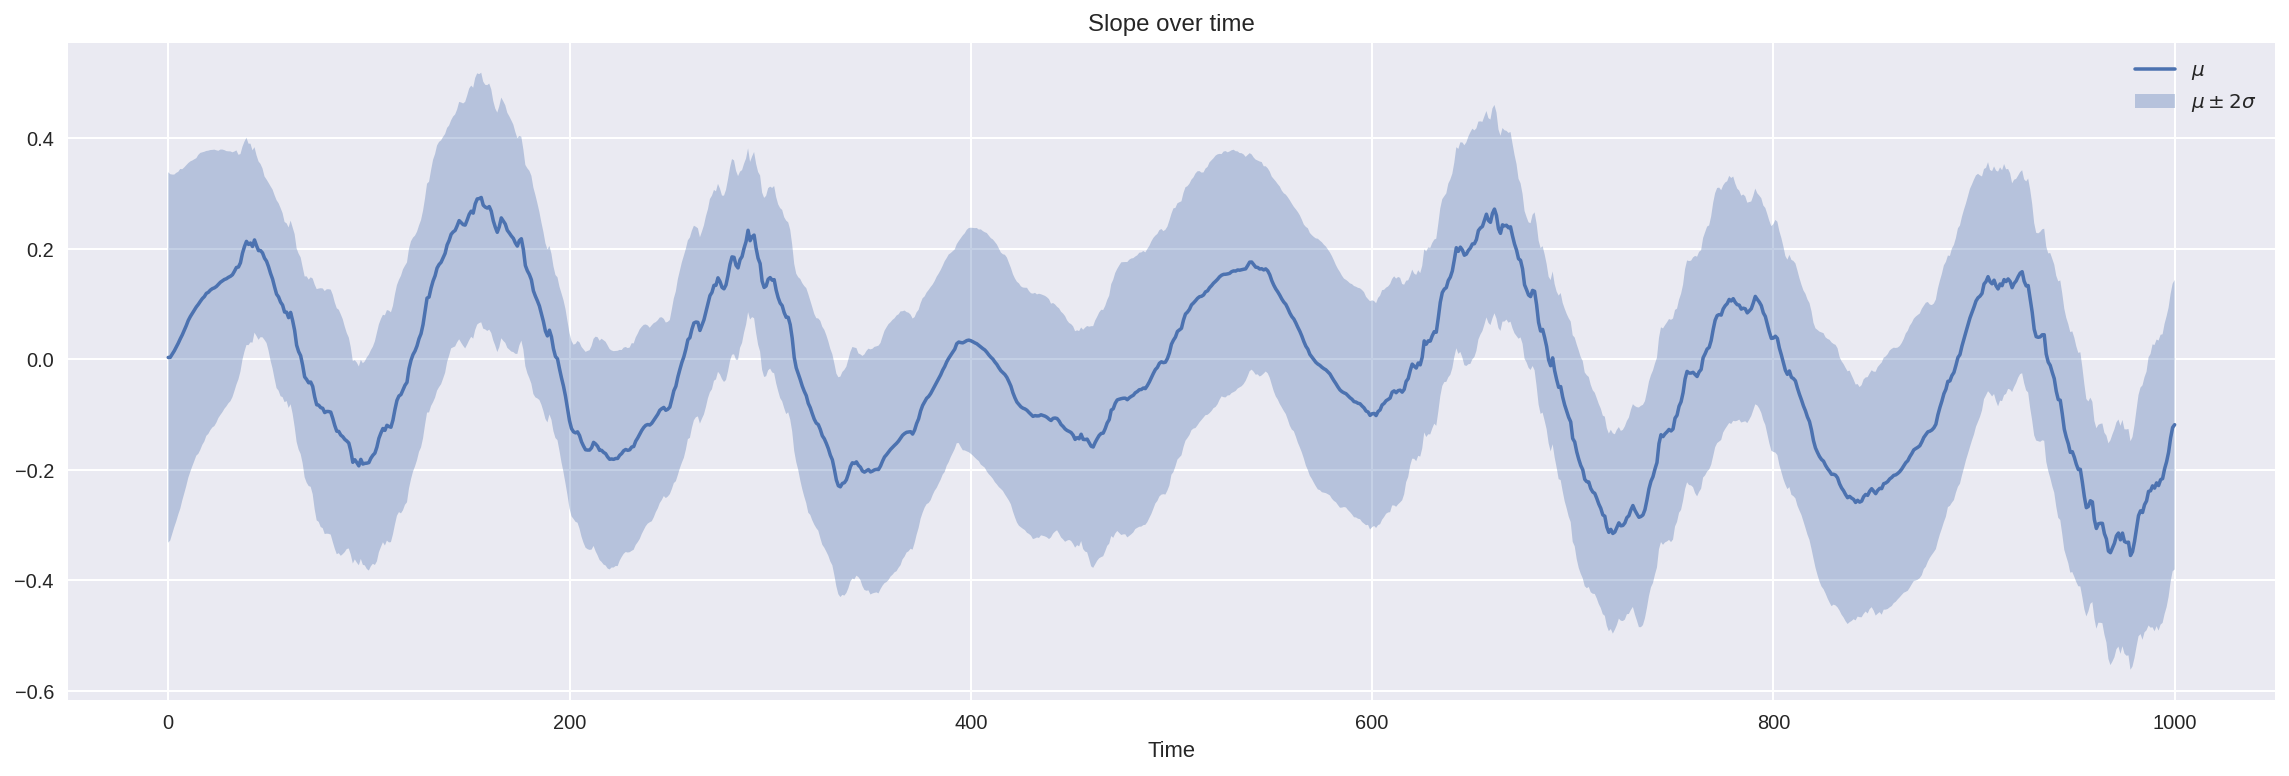

In [72]:
# Extract the means and standard deviations of the slopes
posteriors = rolling_linear_trace.posterior.slopes.values
slopes_means = posteriors.reshape(-1, len(data)).mean(0)
slopes_stds = posteriors.reshape(-1, len(data)).std(0)

# Plot
plt.figure(figsize=FIGSIZE_WIDE)
plt.fill_between(
    range(len(data)),
    slopes_means - 2*slopes_stds,
    slopes_means + 2*slopes_stds,
    alpha=0.33,
    label="$\mu \pm 2 \sigma$"
)
plt.plot(slopes_means, label=r"$\mu$")
plt.title("Slope over time")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()